# Importing and inspecting data

In [18]:
# Importing relevant libraries:
import pandas as pd 
import numpy as np
import regex
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
import time

from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import make_classification
from matplotlib.lines import Line2D
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

# Importing data: 
df_complete = pd.read_csv("/Users/paulinecuperus/Downloads/archive/athlete_events.csv")

# I am interested in the Olympics in a modern context and so will only use data from the last 50 years.
df = df_complete[df_complete["Year"] > 1974]

print(df.head())
print(df.info())
print(df.isnull().sum())

# Check missing data for age, height, and weight:
print("Age missing for {num1}% of athletes".format(num1 = (len(df[df["Age"].notna() == False]) / len(df) * 100)))
print("Height missing for {num2}% of athletes".format(num2 = (len(df[df["Height"].notna() == False]) 
                                                              / len(df) * 100)))
print("Weight missing for {num3}% of athletes".format(num3 = (len(df[df["Weight"].notna() == False]) 
                                                              / len(df) * 100)))

# I will remove all rows with missing data in any of these three columns:
df = df[df["Age"].notna()]
df = df[df["Height"].notna()]
df = df[df["Weight"].notna()]

# Missing data in the column "Medal" is caused by "no medal" being coded as "nan".
# Change "nan" to "No medal":
df["Medal"].fillna("No medal", inplace = True)

# I will consider "successful" to be winning a medal (=1), regardsless of its colour. This will be the outcome
# variable, with the options being "No medal" and "Medal" Therefore, I'll create a new column representing this:
df["Result"] = df.apply(lambda x: "Medal" if x["Medal"] in ["Gold", "Silver", "Bronze"] else "No medal", axis = 1)

print(df.isnull().sum())
# No more missing data

print(df["Team"].unique())
# There appears to be an issue with the "Team" column: Some countries are mentioned several times (e.g.
# France-1)
# -> Use regex to group these together:
df["Team"] = df["Team"].str.replace("[-][\d]", "", regex = True)

print(df["Team"].unique())
# Some of these are not country names. I am fairly sure they are names of horses (based on my limited knowledge
# of equestrian sports). I will replace these manually:

df = df.drop(df[df["Team"].isin(["Mistral Hojris", "Relampago", "Lucky Star", "Briar", "Gran Gesto", "Elvis Va", "Calimucho", "Oxalis", "Don Schufro", "Lancet", "Whisper", "Clearwater", "Bonaparte", "Mythilus", "Rambo", "Floresco",
                                "Brentina", "Nadine", "Pop Art", "Quando Quando", "Diabolo St Maurice", "Ravel", "Notavel", "Galopin De La Font", "Orion", "Greenoaks Dundee", "Sunrise", "Salinero", "Satchmo", "Solos Carex", "Dow Jones", "Digby"])].index)

print(df["Team"].unique())
# Problem solved

print(df.head())

   ID                      Name Sex   Age  Height  Weight         Team  NOC  \
0   1                 A Dijiang   M  24.0   180.0    80.0        China  CHN   
1   2                  A Lamusi   M  23.0   170.0    60.0        China  CHN   
4   5  Christine Jacoba Aaftink   F  21.0   185.0    82.0  Netherlands  NED   
5   5  Christine Jacoba Aaftink   F  21.0   185.0    82.0  Netherlands  NED   
6   5  Christine Jacoba Aaftink   F  25.0   185.0    82.0  Netherlands  NED   

         Games  Year  Season         City          Sport  \
0  1992 Summer  1992  Summer    Barcelona     Basketball   
1  2012 Summer  2012  Summer       London           Judo   
4  1988 Winter  1988  Winter      Calgary  Speed Skating   
5  1988 Winter  1988  Winter      Calgary  Speed Skating   
6  1992 Winter  1992  Winter  Albertville  Speed Skating   

                                Event Medal  
0         Basketball Men's Basketball   NaN  
1        Judo Men's Extra-Lightweight   NaN  
4    Speed Skating Women's

# Exploratory data analysis

In [21]:
print("There are {number} countries that have participated in the Olympics since 1974".format(number = df["Team"].nunique()))
print("There are {number} sports that have been present the Olympics since 1974".format(number = df["Sport"].nunique()))
print("{number} men have participated in the Olympics since 1974".format(number = len(df[df["Sex"] == "M"])))
print("{number} women have participated in the Olympics since 1974".format(number = len(df[df["Sex"] == "F"])))
print("Number of medals at Summer Olympics: {number}".format(number = len(df[(df["Season"] == "Summer") & (df["Result"] == "Medal")])))
print("Number of medals at Winter Olympics: {number}".format(number = len(df[(df["Season"] == "Winter") & (df["Result"] == "Medal")])))

There are 218 countries that have participated in the Olympics since 1974
There are 51 sports that have been present the Olympics since 1974
100038 men have participated in the Olympics since 1974
57580 women have participated in the Olympics since 1974
Number of medals at Summer Olympics: 18907
Number of medals at Winter Olympics: 4021


In [ ]:
# Inspect people's age, height, and weight in the "medal" vs "no medal" categories:
print(df[df["Result"] == "Medal"]["Age"].mean())
print(df[df["Result"] == "No medal"]["Age"].mean())
print(df[df["Result"] == "Medal"]["Height"].mean())
print(df[df["Result"] == "No medal"]["Height"].mean())
print(df[df["Result"] == "Medal"]["Weight"].mean())
print(df[df["Result"] == "No medal"]["Weight"].mean())

# There appear to be some differences here. I will use boxplots to visualise these differences:

# Create a figure with three subplots:
fig, axes = plt.subplots(1, 3, figsize = (12, 5))

# Create boxplots with the variables of interest:
sns.boxplot(data = df, x = "Result", y = "Age", ax = axes[0])
axes[0].set_title("Age distribution (no medal vs medal)")

sns.boxplot(data = df, x = "Result", y = "Height", ax = axes[1])
axes[1].set_title("Height distribution (no medal vs medal)")

sns.boxplot(data = df, x = "Result", y = "Weight", ax = axes[2])
axes[2].set_title("Weight distribution (no medal vs medal)")

plt.tight_layout()
plt.show()

# It is clear that there's a substantial number of outliers in both categories, for all numeric variables that we've
# looked at here. While there is overlap between the two, it seems that visually, the "medal" category has higher 
# age, height, and weight than the "no medal" category.

# Q1) What are the most successful countries per edition of the Olympics?

In [ ]:
df_results_by_country_year = df.groupby(["Year", "Team"])["Result"].value_counts().reset_index(name = "Count")

# Exclude instances of "No medal":
df_results_by_country_year = df_results_by_country_year[df_results_by_country_year["Result"] == "Medal"]

# For each year, sort the "Count" column by frequency:
df_results_by_country_year = df_results_by_country_year.sort_values(by = ["Year", "Count"], ascending = [True, False])

# Create a figure that will contain the subplots:
number_of_years = len(df_results_by_country_year["Year"].unique())
fig, axs = plt.subplots(number_of_years, figsize = (8, 5 * number_of_years))

# For each year, plot the ten most successful countries:
for i, year in enumerate(df_results_by_country_year["Year"].unique()):
    
    # Get the ten countries with the highest number of medals:
    data = df_results_by_country_year[df_results_by_country_year["Year"] == year][["Team", "Count"]][:11]
    
    # Plot these countries
    sns.barplot(data, x = "Team", y = "Count", ax = axs[i])  
    axs[i].set_xlabel("Country")
    axs[i].set_ylabel("Number of medals")
    axs[i].set_title("Best performing countries at the {year} Olympics".format(year = year))
    axs[i].tick_params(axis = "x", rotation = 45)    

plt.tight_layout()
plt.show()

# Some interesting observations here: 
# 1) There are some countries that perform well in most editions of the Olympics (most notably the USA (except 1980
# Olympics which they boycotted), the Soviet Union / Russia, Germany, to some extent also China).
# 2) There are some countries (e.g., Canada, Sweden, Norway, Netherlands) that do well sometimes (as they likely 
# perform well particularly in the winter Olympics)
# 3) There seems to be a trend of the best performing country receiving fewer medals in more recent editions
# Compared to earlier ones (i.e. are the Olympics gaining traction in "smaller countries"?)

# Q2: Has the proportion of female athletes and proportion of medals won by women changed over time since 1974?

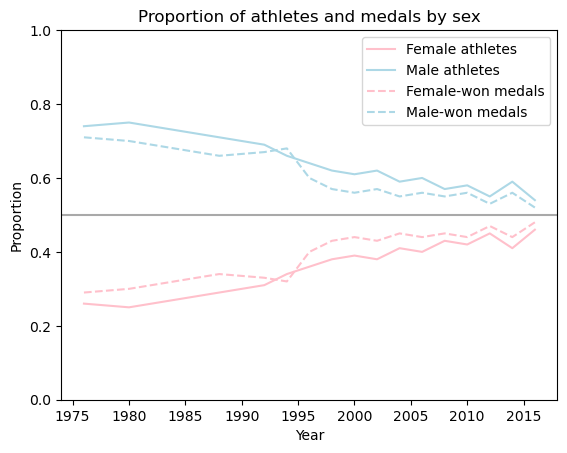

In [4]:
# Just to clarify, this is refering to the a) the proportion of all athletes that is female (aka what proportion of
# the participating athletes identified as female?) and 2) the proportion of medals that was awarded to women (aka out
# of all medals that were awarded, what proportion was awarded to athletes identifying as women?. 

# First do this for proportion of ATHLETES
participants_by_sex = df.groupby(["Year", "Sex"]).count().reset_index()[["Year", "Sex", "ID"]]
participants_by_sex.rename(columns = {"ID": "Count"}, inplace = True)
participants_by_sex["Proportion"] = participants_by_sex.apply(lambda x: round(x["Count"]/participants_by_sex[participants_by_sex["Year"] == x["Year"]]["Count"].sum(), 2), axis = 1)
sns.lineplot(data = participants_by_sex, x = "Year", y = "Proportion", hue = "Sex", palette = ["pink", "lightblue"])

# Next, do this for proportion of MEDALS
medals_by_sex = df.groupby(["Year", "Sex"])["Result"].value_counts().reset_index()
medals_by_sex["Proportion"] = medals_by_sex.apply(lambda x: round(x["count"]/medals_by_sex[(medals_by_sex["Year"] == x["Year"]) & (medals_by_sex["Result"] == "Medal")]["count"].sum(), 2), axis = 1)
# Drop "no medal":
medals_by_sex = medals_by_sex[medals_by_sex["Result"] == "Medal"]
sns.lineplot(data = medals_by_sex, x = "Year", y = "Proportion", hue = "Sex", palette = ["pink", "lightblue"], linestyle = "dashed")

plt.title("Proportion of athletes and medals by sex")
ax = plt.gca()
ax.set_ylim([0, 1])
ax.axhline(y = 0.5, color = "darkgrey")

# Adjust legend manually (line styles not showing up otherwise):
line_1 = Line2D([0], [0], color = "pink", linestyle = "-")
line_2 = Line2D([0], [0], color = "lightblue", linestyle = "-")
line_3 = Line2D([0], [0], color = "pink", linestyle = "dashed")
line_4 = Line2D([0], [0], color = "lightblue", linestyle = "dashed")
ax.legend([line_1, line_2, line_3, line_4], ["Female athletes", "Male athletes", "Female-won medals", "Male-won medals"], loc = "best")

# We can clearly see that both the proportion of female athletes, as well as the proportion of medals that are won
# by women have steadily increased since 1974. The proportion of medals that are won by women is consistently higher
# than the proportion of female athletes (except in 1995), and the medals that are now won are now very close
# to being evenly distributed between men and women, with the distribution of athletes following closely, but
# being slightly further away from being equal.


# Q3: Are there more medals to be won for some sports compared to others?

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 [Text(0, 0, 'Athletics'),
  Text(1, 0, 'Swimming'),
  Text(2, 0, 'Rowing'),
  Text(3, 0, 'Ice Hockey'),
  Text(4, 0, 'Hockey'),
  Text(5, 0, 'Handball'),
  Text(6, 0, 'Canoeing'),
  Text(7, 0, 'Football'),
  Text(8, 0, 'Basketball'),
  Text(9, 0, 'Gymnastics'),
  Text(10, 0, 'Volleyball'),
  Text(11, 0, 'Fencing'),
  Text(12, 0, 'Wrestling'),
  Text(13, 0, 'Cycling'),
  Text(14, 0, 'Water Polo'),
  Text(15, 0, 'Cross Country Skiing'),
  Text(16, 0, 'Sailing'),
  Text(17, 0, 'Boxing'),
  Text(18, 0, 'Judo'),
  Text(19, 0, 'Equestrianism'),
  Text(20, 0, 'Shooting'),
  Text(21, 0, 'Weightlifting'),
  Text(22, 0, 'Speed Skating'),
  Text(23, 0, 'Biathlon'),
  Text(24, 0, 'Baseball'),
  Text(25, 0, 'Alpine Skiing'),
  Text(26, 0, 'Short Track Speed Skating'),
  T

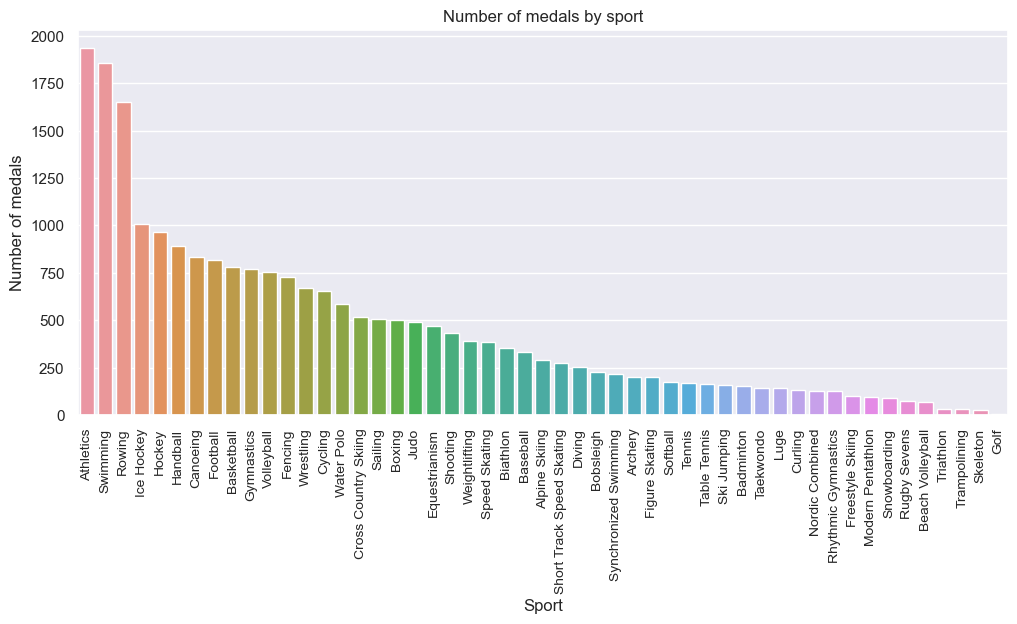

In [6]:
# Group data by sport
medals_by_sport = df.groupby(["Sport"])["Result"].value_counts().reset_index()

# Select only instances where people won a medal:
medals_by_sport = medals_by_sport[medals_by_sport["Result"] == "Medal"]

# Sort data (with highest number of medals first):
medals_by_sport = medals_by_sport.sort_values(by = "count", ascending = False)

# Visualise the data:
sns.barplot(data = medals_by_sport, x = "Sport", y = "count")
sns.set(rc = {"figure.figsize" : (12, 5)})
plt.xlabel("Sport")
plt.ylabel("Number of medals")
plt.title("Number of medals by sport")
plt.xticks(rotation = 90, fontsize = 10)

# Clearly there are more medals to be won in some sports compared to others. The sports that offer the highest 
# number of medals are: Athletics (perhaps not surprising given that his encompasses a large number of different
# disciplines), swimming, rowing, ice hockey, and hockey. 

# Modeling: Can we predict who will win a medal?

In [22]:
# I would now like to use a random forest classifier to see whether we can predict whether or not someone will
# win a medal in the Olympics.

# Transform "Result" column so that "no medal" = 0 and "medal" = 1
df["Result"] = df["Result"].replace({"No medal": 0, "Medal": 1})

# Transform "Sex" column so that "F" = 0, "M" = 1
df["Sex"] = df["Sex"].replace({"F": 0, "M": 1})

# Transform "Sex" column so that "F" = 0, "M" = 1
df["Season"] = df["Season"].replace({"Winter": 0, "Summer": 1})

# I will use binary encoding for "Team" and "Sport", given that:
# 1) This does not assume ordinal relationships in the data (as label encoding would)
# 2) This does not create a very sparse matrix (as one-hot encoding would)
columns_to_encode = ["Team", "Sport"]

# Initialise binary encoder + apply this to the specified columns:
binary_encoder = ce.BinaryEncoder(cols = columns_to_encode)
df_encoded = binary_encoder.fit_transform(df)

# Split data into features and target variable:
# X = df_encoded.drop(["Result", "ID", "Name", "City", "Event", "Medal", "NOC", "Games", "Year", "Season"], axis = 1)
X = df_encoded.drop(["Result", "ID", "Name", "City", "Event", "Medal", "NOC", "Games", "Year"], axis = 1)
y = df_encoded["Result"]

# Split data into training and test sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

# Initialise and train random forest classifier:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

# Evaluate the model:
accuracy = rfc.score(X_test, y_test)
print(accuracy)

0.8624222814363659


In [14]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
y_pred = rfc.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[25443  1434]
 [ 2872  1775]]


    Feature  Importance
1       Age    0.232872
3    Weight    0.213089
2    Height    0.202120
10   Team_6    0.035092
9    Team_5    0.032091
18  Sport_5    0.029158
15  Sport_2    0.028379
17  Sport_4    0.027366
7    Team_3    0.024419
11   Team_7    0.023934
6    Team_2    0.021606
14  Sport_1    0.021543
8    Team_4    0.019236
16  Sport_3    0.018934
0       Sex    0.017125
13  Sport_0    0.016459
5    Team_1    0.013469
12   Season    0.013305
4    Team_0    0.009803


Text(0.5, 1.0, 'Random forest classifier feature importance')

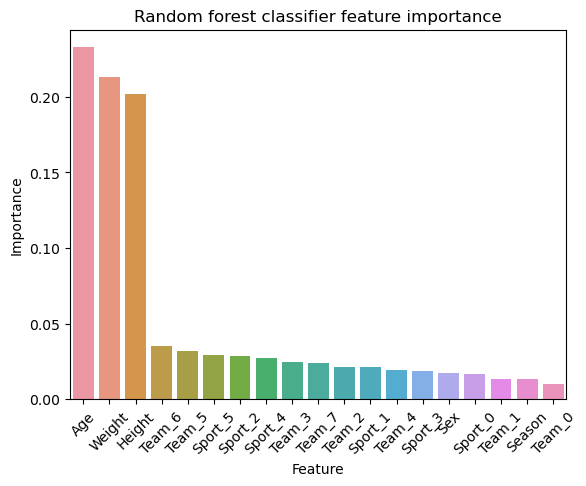

In [15]:
# Which features are the most important?
importances = rfc.feature_importances_

# Display these in a dataframe:
feature_importances = pd.DataFrame({"Feature": X.columns, "Importance": importances})
feature_importances = feature_importances.sort_values(by = "Importance", ascending = False)

print(feature_importances)
# The most important features are age, weight, and height.

# Plot feature importances:
sns.barplot(data = feature_importances, x = "Feature", y = "Importance")
plt.xticks(rotation = 45)
plt.title("Random forest classifier feature importance")


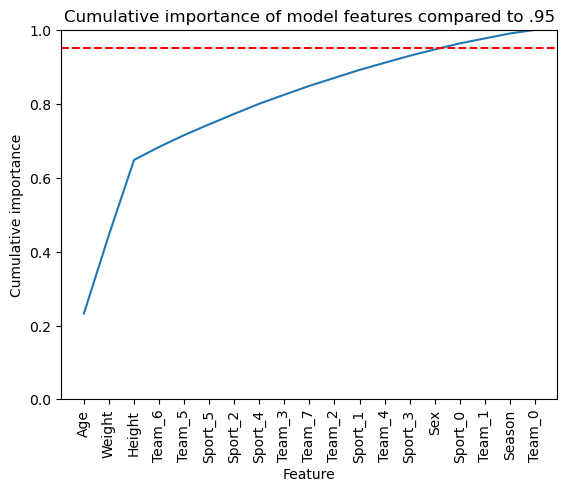

0.8569343991879204


In [25]:
# CHECK: Can we drop some of these features without significant performance loss in order to improve runtime?    
# I will compare the cumulative model performance with the randomly chosen value of .95.
cumulative_importance = np.cumsum(feature_importances["Importance"])
x_values = list(range(len(importances)))

plt.plot(x_values, cumulative_importance)
plt.xticks(x_values, feature_importances["Feature"], rotation = 90)
plt.xlabel("Feature")
plt.ylabel("Cumulative importance")
plt.title("Cumulative importance of model features compared to .95")
ax = plt.gca()
ax.set_ylim([0, 1])
ax.axhline(y = 0.95, color = "red", linestyle = "--")
plt.show()

# We can drop the five least important features ("Sex", "Sport_0", "Team_1", "Season", "Team_0") and achieve 95% 
# cumulative importance.
# Re-run model without these three features:
X_reduced = X.drop(["Sex", "Sport_0", "Team_1", "Season", "Team_0"], axis = 1)
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y, test_size = .2, random_state = 42)

# Initialise and train random forest classifier:
rfc = RandomForestClassifier()
rfc.fit(X_train_reduced, y_train_reduced)

# Evaluate the model:
reduced_model_accuracy = rfc.score(X_test_reduced, y_test_reduced)
print(reduced_model_accuracy)
# This results in minor accuracy loss (±0.859 instead of ± 0.863)

In [26]:
# How does the run time differ when the five least important variables are dropped?

# Create function to calculate the runtime:
def required_time(train_features, train_labels, test_features):
    
    classifier = RandomForestClassifier()
    start_time = time.time()
    classifier.fit(train_features, train_labels)
    y_pred = classifier.predict(test_features)
    end_time = time.time()
    runtime = end_time - start_time
    
    return runtime

# Calculate the runtime for the full model and the reduced model that has dropped the three least important features:
full_model_time = required_time(X_train, y_train, X_test)
reduced_model_time = required_time(X_train_reduced, y_train_reduced, X_test_reduced)

# Display the accuracy and the runtime in dataframe:
df_model_comparison = pd.DataFrame({"# of features": [len(X_train.columns), len(X_train_reduced.columns)], "Accuracy": [accuracy, reduced_model_accuracy], "Runtime": [full_model_time, reduced_model_time]})
df_model_comparison.rename(index = {0 : "Full model", 1 : "Reduced model"}, inplace = True)
print(df_model_comparison)

# Calculate the percentage of time and accuracy that is lost / gained through dropping the three least important
# features
time_gain_percentage = ((full_model_time - reduced_model_time) / full_model_time) * 100
accuracy_loss_percentage = ((accuracy - reduced_model_accuracy) / accuracy) * 100

print(time_gain_percentage)
print(accuracy_loss_percentage)

# By leaving out the three least important features, we can decrease runtime by 17.23% while only reducing accuracy
# by .63%. This might be worth considering depending on our priorities. 

               # of features  Accuracy    Runtime
Full model                19  0.862422  17.504041
Reduced model             14  0.856934  14.488057
17.2302145970589
0.6363335417662753
